# WiDS 2025
### Sex Patterns in ADHD

### Import

In [3]:
import pandas as pd
import numpy as np
import math


from sklearn.compose import ColumnTransformer
from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
# from sklearn.linear_model import MultiTaskElasticNetCVl


In [4]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [5]:
connectome_train.head(5)

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_196thcolumn,195throw_197thcolumn,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,0.003404,-0.010359,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,-0.008409,-0.008479,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.053245,-0.028003,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,-0.023918,-0.005356,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,0.066439,-0.076680,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269


### Reshaping the connectome data set to fill in the lower triagnle of the matrix

In [7]:
import pandas as pd
import numpy as np

# Load your CSV file into a DataFrame
# Replace 'your_file.csv' with your actual file name
df = connectome_train
df = df.drop(columns=['participant_id'])

# Initialize parameters
grid_size = 200
num_rows = len(df)  # Number of rows in the dataset

# Create a list to store all 200x200 grids
all_grids = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Initialize an empty 200x200 array for the current row
    grid = np.zeros((grid_size, grid_size))
    
    # Iterate over the DataFrame's columns
    for col in df.columns:
        parts = col.split('throw_') 
        x = int(parts[0])  # Extract x (row index)

        col_parts = parts[1].split('thcolumn') 
        y = int(col_parts[0])  # Extract y (column index)
        
        # Assign values to the upper triangle
        grid[x, y] = row[col]  # Use the current row's data
        # Mirror the values to the lower triangle
        if x != y:  # Avoid duplicating diagonal elements
            grid[y, x] = grid[x, y]
    
    for i in range(200):
        grid[i, i] = 1

    # Append the completed grid to the list
    all_grids.append(grid)



# for col in df.columns:
#     # Parse the column name to extract row (x) and column (y) indices
#     parts = col.split('throw_') 
#     x = int(parts[0])  # Extract x (row index)

#     col_parts = parts[1].split('thcolumn') 
#     y = int(col_parts[0])  # Extract y (column index)
#     print(x, y)
    
#     # Assign values to the upper triangle
#     full_grid[x, y] = df[col].values[0]  # Assuming a single row of data per file

#     # Mirror the values to the lower triangle
#     if x != y:  # Avoid duplicating diagonal elements
#         full_grid[y, x] = full_grid[x, y]

# for i in range(200):
#     full_grid[i, i] = 1

# `all_grids` is now a list of 200x200 numpy arrays
print(f"Generated {len(all_grids)} grids.")

# Access the grid for a specific row if needed
# For example, access the grid for the first row
first_grid = all_grids[0]
print(first_grid)

Generated 1213 grids.
[[ 1.          0.09347303  0.14690234 ... -0.04479052  0.02823504
  -0.02086464]
 [ 0.09347303  1.         -0.07039627 ... -0.03046599 -0.01168959
   0.0476122 ]
 [ 0.14690234 -0.07039627  1.         ...  0.09710624 -0.00213528
   0.07827996]
 ...
 [-0.04479052 -0.03046599  0.09710624 ...  1.          0.02822832
   0.13358206]
 [ 0.02823504 -0.01168959 -0.00213528 ...  0.02822832  1.
   0.14337176]
 [-0.02086464  0.0476122   0.07827996 ...  0.13358206  0.14337176
   1.        ]]


### Exporting the new 200x200 matrices to a npy file - I already ran this so you don't have to

In [11]:
# import numpy as np

# # Save all grids to a single .npy file
# np.save('all_grids.npy', np.array(all_grids))

# # Load the grids later
# loaded_grids = np.load('all_grids.npy')
# print(loaded_grids.shape)  # Should print (num_rows, 200, 200)

(1213, 200, 200)


In [20]:
# Map the participant_id in npy to the label in the training solution csv
#  all_grids[1] - map to the right label in the training solution csv
#  

type(label) # solution file
print(label.shape)
label

# all_grids[i] = ith patient
# map[i] = corresponding row in training_solutions
# label[map[i]] = label for ith patient


(1213, 3)


,participant_id,ADHD_Outcome,Sex_F
0,UmrK0vMLopoR,1,1
1,CPaeQkhcjg7d,1,0
2,Nb4EetVPm3gs,1,0
3,p4vPhVu91o4b,1,1
4,M09PXs7arQ5E,1,1
...,...,...,...
1208,Atx7oub96GXS,0,0
1209,groSbUfkQngM,0,1
1210,zmxGvIrOD0bt,0,1
1211,rOmWFuJCud5G,0,0


In [24]:
a1 = connectome_train.join(label.set_index('participant_id'), on='participant_id')
a1[['participant_id', 'Sex_F', 'ADHD_Outcome']]
# df1 = df[['a', 'b']]

,participant_id,Sex_F,ADHD_Outcome
0,70z8Q2xdTXM3,0,1
1,WHWymJu6zNZi,1,1
2,4PAQp1M6EyAo,1,1
3,obEacy4Of68I,1,1
4,s7WzzDcmDOhF,1,1
...,...,...,...
1208,kTurROKp5YHQ,1,0
1209,FCRyMz9O6yCq,0,1
1210,vm2P1hmAY1hl,1,0
1211,OFxvN8lnw21w,1,1


In [47]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [48]:
train = connectome_train.merge(label, on= 'participant_id')
# Assuming 'ADHD_Outcome' is the column name for labels
labels = train['ADHD_Outcome'].values


In [ ]:
# Drop 'ADHD_Outcome' from the features
data = train.drop(columns=['ADHD_Outcome','participant_id','Sex_F']).values
print(f"Features shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

data

In [42]:
# # Find the index of the first Non-ADHD participant (label == 0)
# non_adhd_index = np.where(labels == 0)[0][0]  # First Non-ADHD participant
# print(non_adhd_index)

# # Find the index of the first ADHD participant (label == 1)
# adhd_index = np.where(labels == 1)[0][0]  # First ADHD participant
# print(adhd_index)

1
0


In [28]:
a1

,participant_id,0throw_1thcolumn,0throw_2thcolumn,0throw_3thcolumn,0throw_4thcolumn,0throw_5thcolumn,0throw_6thcolumn,0throw_7thcolumn,0throw_8thcolumn,0throw_9thcolumn,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,70z8Q2xdTXM3,0.093473,0.146902,0.067893,0.015141,0.070221,0.063997,0.055382,-0.035335,0.068583,...,-0.050968,-0.014365,0.128066,0.112646,-0.058980,0.028228,0.133582,0.143372,1,0
1,WHWymJu6zNZi,0.029580,0.179323,0.112933,0.038291,0.104899,0.064250,0.008488,0.077505,-0.004750,...,0.020891,0.017754,0.094040,0.035141,0.032537,0.075007,0.115350,0.138200,1,1
2,4PAQp1M6EyAo,-0.051580,0.139734,0.068295,0.046991,0.111085,0.026978,0.151377,0.021198,0.083721,...,0.028773,0.024556,0.166343,0.058925,0.035485,0.063661,0.042862,0.162162,1,1
3,obEacy4Of68I,0.016273,0.204702,0.115980,0.043103,0.056431,0.057615,0.055773,0.075030,0.001033,...,0.018607,0.016193,0.072955,0.130135,0.056120,0.084784,0.114148,0.190584,1,1
4,s7WzzDcmDOhF,0.065771,0.098714,0.097604,0.112988,0.071139,0.085607,0.019392,-0.036403,-0.020375,...,-0.047530,-0.031443,0.221213,0.007343,0.005763,0.083820,0.079582,0.067269,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1208,kTurROKp5YHQ,0.022932,0.024830,-0.006514,0.021070,0.093365,0.083369,0.010991,0.035838,0.023909,...,-0.016413,0.089110,0.118587,-0.060868,0.124443,0.028510,0.113064,0.103809,0,1
1209,FCRyMz9O6yCq,0.047078,0.135955,0.144366,0.054938,0.065760,0.113550,0.032621,0.025349,0.011848,...,-0.020920,0.030450,0.190241,0.026461,-0.011593,0.139483,-0.064480,0.070354,1,0
1210,vm2P1hmAY1hl,0.094541,0.145280,0.061964,0.030562,0.078278,0.105857,0.043984,0.039145,0.032024,...,-0.038452,0.066608,0.143446,0.051221,0.127495,0.106242,-0.036065,0.151341,0,1
1211,OFxvN8lnw21w,-0.001533,0.128562,0.045000,-0.008742,0.003673,0.086494,0.090101,-0.037449,-0.026334,...,-0.061617,-0.001699,0.106568,0.023427,-0.003520,0.174972,0.041198,0.152029,1,1


### Visualizing the connectome data

There are 1213 connectomes: [382] Non-ADHD and [831] ADHD patients.
Shape of first connectome: (200, 200), Data type: float64


Text(0.5, 1.0, 'Non-ADHD')

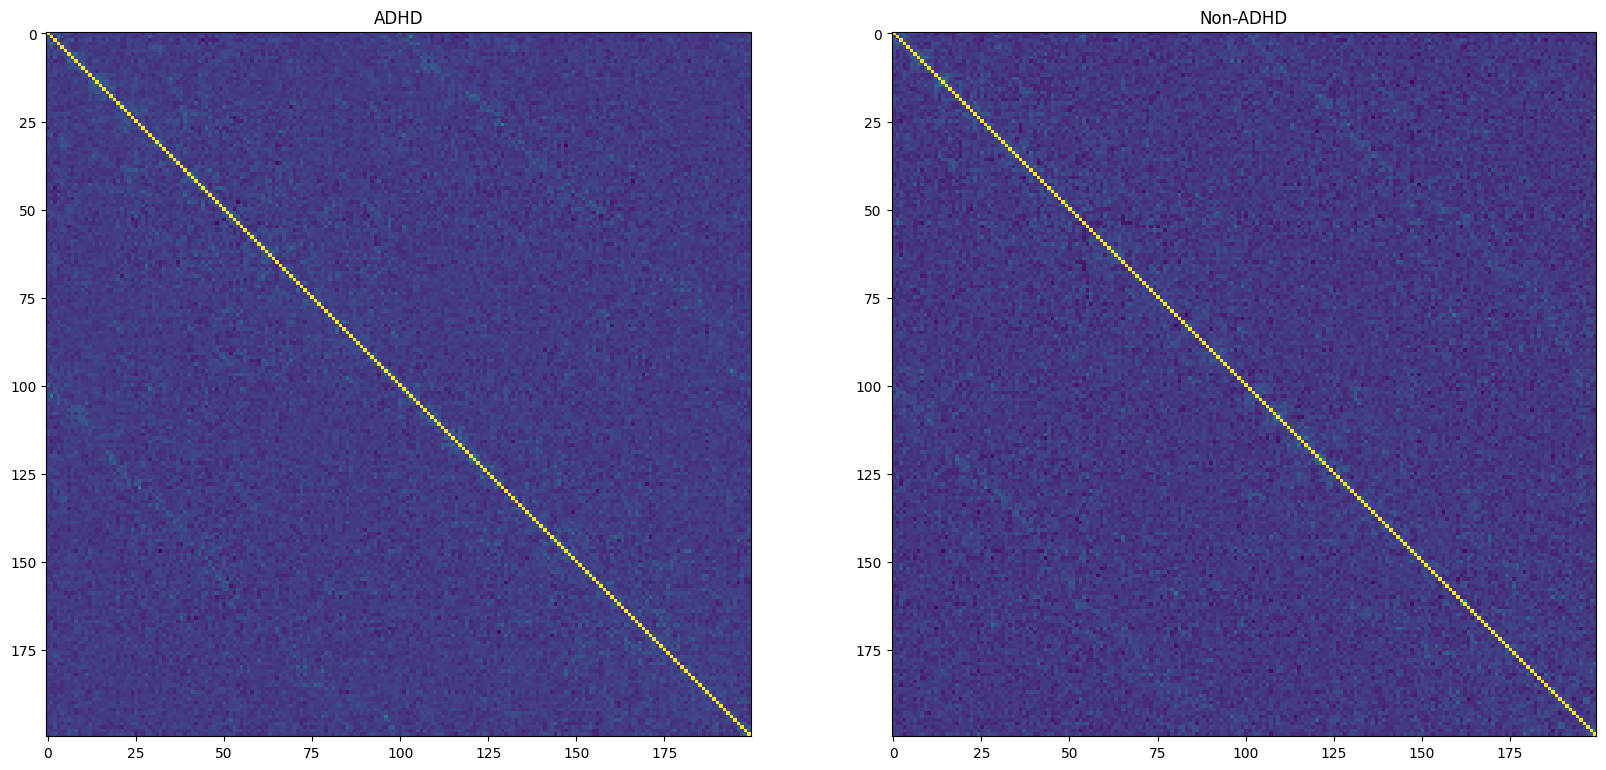

In [ ]:
labels_adhd = a1[['ADHD_Outcome']].values
labels_sex = a1[['Sex_F']]

print(f"There are {len(all_grids)} connectomes:"
      f" {sum(labels_adhd == 0)} Non-ADHD and {sum(labels_adhd == 1)} ADHD patients.")
 
labels_str = ["Non-ADHD", "ADHD"]
 

# Check shapes and data types
print(f"Shape of first connectome: {all_grids[0].shape}, Data type: {all_grids[0].dtype}")

# Plot the first connectomes
fig = plt.figure(figsize=(20,10))
 
ax = fig.add_subplot(121)
imgplot = ax.imshow(all_grids[0]); ax.set_title(labels_str[labels[0]])
 
ax = fig.add_subplot(122)
imgplot = ax.imshow(all_grids[1]); ax.set_title(labels_str[labels[1]])

Text(0.5, 1.0, 'ADHD')

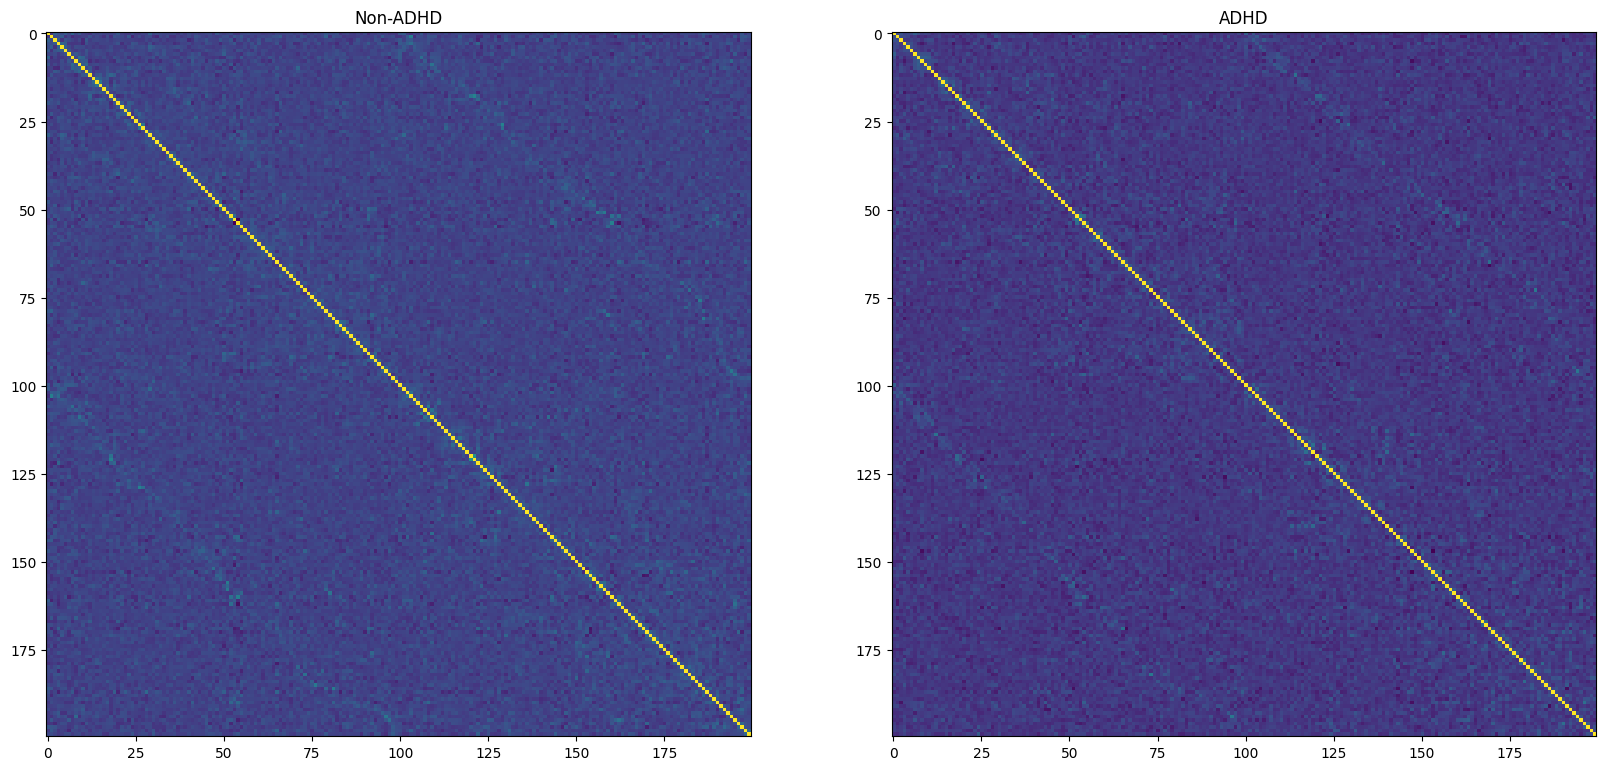

In [46]:
# Plot the first connectomes
fig = plt.figure(figsize=(20,10))
 
ax = fig.add_subplot(121)
imgplot = ax.imshow(all_grids[2]); ax.set_title(labels_str[labels[2]])
 
ax = fig.add_subplot(122)
imgplot = ax.imshow(all_grids[10]); ax.set_title(labels_str[labels[10]])

In [40]:
# labels_adhd = a1[['ADHD_Outcome']].values
# print(labels_adhd[0,0])

1


In [56]:
from geomstats.geometry.spd_matrices import SPDMatrices
all_grids = np.array(all_grids)
spd_manifold = SPDMatrices (n=200, equip=True)
spd_manifold.belongs(all_grids)



array([ True,  True,  True, ..., False,  True, False])

In [57]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean

mdm = RiemannianMinimumDistanceToMean(space=spd_manifold)
mdm.classes_ = 2

In [64]:
from sklearn.model_selection import train_test_split
X= all_grids; y= labels_adhd
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

print(f"The dataset has {len(X)} connectomes.")
print(f"The train dataset has {len(X)} connectomes and has size {X_train.shape}.")
print(f"The test dataset has {len(X)} connectomes and has size {X_test.shape}.")

The dataset has 1213 connectomes.
The train dataset has 1213 connectomes and has size (909, 200, 200).
The test dataset has 1213 connectomes and has size (304, 200, 200).


In [67]:
# mdm.fit(X_train, y_train)
y_train = y_train.flatten()
mdm.fit(X_train, y_train)

c:\Users\tienn\AppData\Local\Programs\Python\Python312\Lib\site-packages\geomstats\_backend\_dtype_utils.py:389: RuntimeWarning: invalid value encountered in log
  return func(x, *args, **kwargs)


KeyboardInterrupt: 

In [63]:
mdm.score(X_test, y_test)

AttributeError: 'NoneType' object has no attribute 'ndim'

There are 86 connectomes: 46 healthy and 40 schizophrenic patients.


Text(0.5, 1.0, 'Healthy')

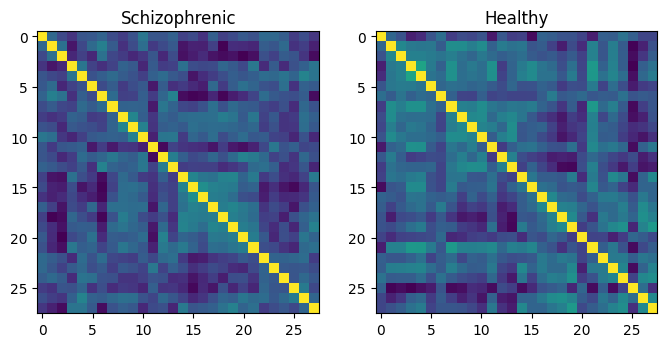

In [13]:
import geomstats.datasets.utils as data_utils
data, _, labels = data_utils.load_connectomes()
print(f"There are {len(data)} connectomes:"
      f" {sum(labels == 0)} healthy and {sum(labels == 1)} schizophrenic patients.")
 
labels_str = ["Healthy", "Schizophrenic"]
 
# Plot the first connectomes
fig = plt.figure(figsize=(8,4))
 
ax = fig.add_subplot(121)
imgplot = ax.imshow(data[0]); ax.set_title(labels_str[labels[0]])
 
ax = fig.add_subplot(122)
imgplot = ax.imshow(data[1]); ax.set_title(labels_str[labels[1]])

In [15]:
print(data.shape)

(86, 28, 28)


In [ ]:
type(data)

In [49]:
from geomstats.geometry.spd_matrices import SPDMatrices

spd_manifold = SPDMatrices (n=28, equip=True)
spd_manifold.belongs(data)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [26]:
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean

mdm = RiemannianMinimumDistanceToMean(space=spd_manifold)
mdm.classes_ = 2

In [ ]:
from sklearn.model_selection import train_test_split
X= data; y= labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47)

print(f"The dataset has {len(X)} connectomes.")
print(f"The train dataset has {len(X)} connectomes and has size {X_train.shape}.")
print(f"The set dataset has {len(X)} connectomes and has size {X_test.shape}.")

In [ ]:
mdm.fit(X_train, y_train)
mdm.score(X_test, y_test)

In [ ]:
mdm.score(X_test, y_test)

In [ ]:
pip install geomstats

In [ ]:
pip show geomstats

In [ ]:
data_array = train.values
data_array

In [4]:
train = connectome_train.merge(quan_train, on= 'participant_id').merge(cat_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [5]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

In [ ]:
# Explore Null data
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

In [ ]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

In [ ]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

In [ ]:
label.Sex_F.value_counts()
# 797 M, 416 F

In [ ]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

In [ ]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

In [16]:
connectome_train.set_index('participant_id', inplace= True)

In [17]:
df = connectome_train.iloc[:,:5]

In [ ]:
df

# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Preprocessing
A pipeline that transform categorical into one-hot code, and quant data into a standard scaler

In [19]:
# Remove 2 features with null
train = train.drop(['MRI_Track_Age_at_Scan', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1)
categorical_features = list(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis= 1).columns)
numeric_features = train.drop(cat_train.drop(['participant_id', 'PreInt_Demos_Fam_Child_Ethnicity'], axis = 1).columns, axis = 1).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

### Train - test split


In [20]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [ ]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

### Visual call-out Functions

In [23]:
def model_result(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print('Accuracy: ', accuracy)
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")
    print('f1: ', f1_score(y_test, y_pred))

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Logistic Regression for each task

In [ ]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', (LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train.iloc[:,0])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
#f1 = f1_score(y_test.iloc[:,0],y_pred, average = 'micro')
print(f'f1 score of ADHD Log Regression with L1 : {f1:.2f}')
model_result(y_test['ADHD_Outcome'], y_pred, "ADHD Classifier with Log L1")

In [ ]:
coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

In [ ]:
pipeline.fit(x_train, y_train.iloc[:,1])
log_reg = pipeline.named_steps['classifier']
y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test.iloc[:,1],y_pred, average = 'micro')
print(f'f1 score of Sex Log Regression with L1 : {f1:.2f}')
model_result(y_test['Sex_F'], y_pred, "ADHD Classifier with Log L1")

coefficients = log_reg.coef_[0]  # Coefficients for the single task
feature_names = x_train.columns

# Combine coefficients with feature names
coef_data = list(zip(feature_names, coefficients))

sorted_coef = sorted(coef_data, key=lambda x: abs(x[1]), reverse=True)
sorted_features, sorted_values = zip(*sorted_coef)

# Print sorted coefficients (due to large amount of var, wont produce chart at this time)
print("Sorted Coefficients:")
for feature, coef in sorted_coef:
    print(f"{feature}: {coef:.4f}")

### Multi-output
Perform the same model for both tasks

In [ ]:
# Multi-output model for log classifier with 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(penalty='l1', solver='liblinear')))
])

pipeline.fit(x_train, y_train)

model = pipeline.named_steps['classifier']

y_pred = pipeline.predict(x_test)
f1 = f1_score(y_test,y_pred, average = 'micro')
print(f'f1 score of Multi-output Log Regression with L1 : {f1:.2f}')

Log while produce about less then 0.6 acc for both classes which is a bit over random guess, it produce extremely low f1 score for Gender.

### Multi-task Models
